In [6]:
%load_ext autoreload
%autoreload
from IPython.display import display

In [5]:
import matplotlib.pyplot as plt

In [3]:
import argparse
import torch
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader
import os,random
import os.path as osp
import sys
import time
from utils import *

from mace.mace_gnn import MaceGNN

/n/fs/vl/rb4785/miniforge3/envs/mace_ng/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
from NeuroGraph.datasets import NeuroGraphDataset

In [177]:
root = "/n/fs/scratch/rb4785/NeuroGraph_data/"
dataset = NeuroGraphDataset(root=root, name="HCPAge")

Processing...
Done!


# Spherical Harmonics

In [5]:
from e3nn import o3

In [135]:
i = o3.Irreps([(16, (0,1))])
o3.Irrep(0, 1).count(1)

NotImplementedError: 

In [199]:
ir = o3.Irreps("256x0e + 256x1o")
ir

256x0e+256x1o

In [47]:
import e3nn
from e3nn import o3

In [51]:
sh_irreps = o3.Irreps.spherical_harmonics(3) # spherical harmonics irreps
# up to l=3
print(sh_irreps, sh_irreps.dim)

1x0e+1x1o+1x2e+1x3o 16


In [53]:
sh = o3.SphericalHarmonics(
  sh_irreps, normalize=True, normalization='component'
)

In [54]:
sh(torch.randn((2, 16)))

tensor([[ 1.0000, -0.3883, -0.4902, -0.1420,  0.0712,  0.2458,  0.1154,  0.0898,
         -0.0843,  0.0141, -0.0533, -0.0957,  0.0040, -0.0350,  0.0632,  0.0247],
        [ 1.0000, -0.3779, -0.0536, -0.2273,  0.1109,  0.0262, -0.0703,  0.0157,
         -0.0588, -0.0019, -0.0091,  0.0216,  0.0079,  0.0130,  0.0048,  0.0345]])

# PANDAS

In [15]:
import numpy as np
import pandas as pd
from pandas.io.formats.style import Styler

In [21]:
df = pd.read_csv("results/results_new.csv")
his = pd.read_csv("results/history.csv")
df.sort_values(by=['dataset', 'test_acc'], ascending=[True, False])
df.head()

,label,dataset,model,epochs,best_val_acc,best_val_loss,test_acc,test_loss
0,novecs,HCPAge,MaceGNN,10,0.514019,0.0,0.403756,0.278502
1,novecs,HCPAge,GCNConv,10,0.467290,0.0,0.441315,0.278897
2,novecs,HCPAge,GraphConv,10,0.411215,0.0,0.460094,0.275382
3,novecs,HCPTask,MaceGNN,10,0.728859,0.0,0.713230,0.456199
4,novecs,HCPTask,GCNConv,10,0.602685,0.0,0.581598,0.445058


In [22]:
# additional columns
df['valid_test_acc_diff'] = df.best_val_acc - df.test_acc

In [23]:
#into percentages
df[df.select_dtypes(include=['float64']).columns] *= 100
his[his.select_dtypes(include=['float64']).columns] *= 100
print('Done')

Done


In [24]:
df.head()

,label,dataset,model,epochs,best_val_acc,best_val_loss,test_acc,test_loss,valid_test_acc_diff
0,novecs,HCPAge,MaceGNN,10,51.401869,0.0,40.375587,27.850158,11.026282
1,novecs,HCPAge,GCNConv,10,46.728972,0.0,44.131455,27.889708,2.597517
2,novecs,HCPAge,GraphConv,10,41.121495,0.0,46.009390,27.538182,-4.887894
3,novecs,HCPTask,MaceGNN,10,72.885906,0.0,71.323036,45.619950,1.562870
4,novecs,HCPTask,GCNConv,10,60.268456,0.0,58.159839,44.505768,2.108618


In [35]:
def printstyler(dat, *, stylerargs={}, latexargs={}):
  return Styler(dat, precision=2, **stylerargs).to_latex(hrules=True, clines="all;data", **latexargs).replace("dataset", "Dataset").replace("novecs_w_history", "Zero").replace("randn_vecs", "Random").replace("test_acc", "Test Accuracy").replace("model", "Model")

## Figure 1: Randn vec vs novec
Plot validation accuracy over time, and test accuracy at end.

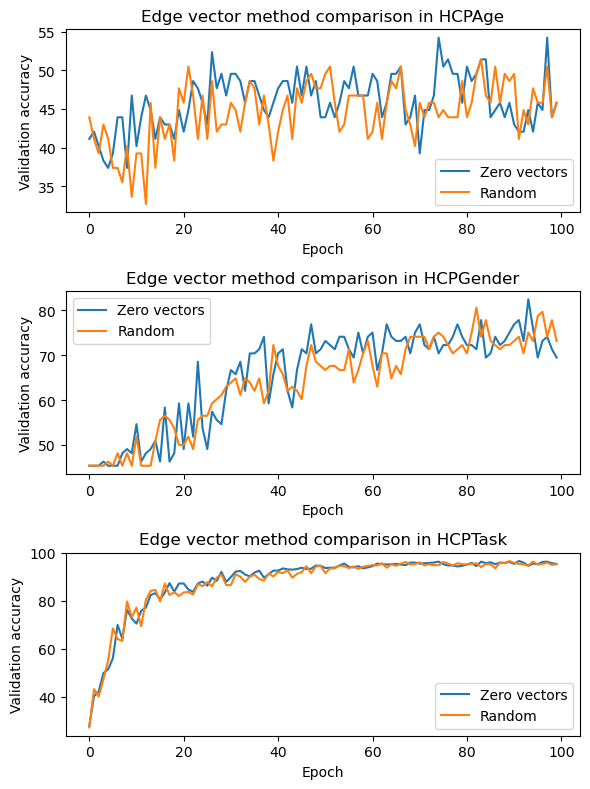

In [27]:
mask1 = (his.model == "MaceGNN") & ((his.label == "novecs_w_history") | (his.label == "randn_vecs"))
# mask1 = (his.model == "MaceGNN")
group1 = his[mask1].groupby(['dataset', 'model'])

names = {
  'novecs_w_history': "Zero vectors",
  'randn_vecs': "Random"
}
fig, axes = plt.subplots(3, figsize=(6, 8))
for i, (title, group) in enumerate(group1):
  ax = axes[i%3]
  group = group.groupby('label')
  for label, g in group:
    g.plot('epoch', 'val_acc', ax=ax, label=(names[label] if label in names else label))
    ax.set_ylabel("Validation accuracy")
    ax.set_xlabel("Epoch")
    ax.set_title(f"Edge vector method comparison in {title[0]}")
fig.tight_layout()
fig.savefig('figures/edge_vec_valids.png')
# print(Styler(dat).to_latex(hrules=True, clines='all;data').replace('_', '\\_'))

In [37]:
# Now show test acc in table
mask1 = (df.epochs == 100) & (df.model == "MaceGNN") & ((df.label == "novecs_w_history") | (df.label == "randn_vecs"))
dat = df[mask1].groupby(['dataset', 'label', 'model'])[['test_acc']].aggregate('mean').droplevel(2)
print(printstyler(dat).replace('label', 'Method'))
dat

\begin{tabular}{llr}
\toprule
 &  & Test Accuracy \\
Dataset & Method &  \\
\midrule
\multirow[c]{2}{*}{HCPAge} & Zero & 45.54 \\
\cline{2-3}
 & Random & 44.60 \\
\cline{1-3} \cline{2-3}
\multirow[c]{2}{*}{HCPGender} & Zero & 86.11 \\
\cline{2-3}
 & Random & 84.72 \\
\cline{1-3} \cline{2-3}
\multirow[c]{2}{*}{HCPTask} & Zero & 95.57 \\
\cline{2-3}
 & Random & 96.84 \\
\cline{1-3} \cline{2-3}
\bottomrule
\end{tabular}



test_acc
dataset   label                      
HCPAge    novecs_w_history  45.539906
          randn_vecs        44.600939
HCPGender novecs_w_history  86.111111
          randn_vecs        84.722222
HCPTask   novecs_w_history  95.567495
          randn_vecs        96.843519

## Fig 2: General results
epochs 100
novecs_w_history, randn_vecs

In [39]:
# df[(df.epochs == 100) & ((df.label == 'novecs') | (df.label == 'randn_vecs') | (df.label == 'novecs_w_history'))].groupby(['dataset', 'model', 'label']).aggregate('sum', 'label')

# df[(df.epochs == 100) & ((df.label == 'novecs') | (df.label == 'randn_vecs') | (df.label == 'novecs_w_history'))].groupby(['dataset', 'label'])[['test_acc']].aggregate('mean')
dats = df[(df.epochs == 100) & (((df.model == "MaceGNN") & (df.label == 'novecs_w_history')) | ((df.model != "MaceGNN") & (df.label == 'randn_vecs')))]
for ds in ("HCPAge", "HCPGender", "HCPTask"):
  dat = dats[dats.dataset == ds].groupby(['dataset', 'model', 'label'])[['test_acc']].aggregate('mean').sort_values(by=['dataset', 'model'], ascending=[True, False]).droplevel(2).transpose()
  print(printstyler(dat))
  print("\\vspace{2mm}\n")
  # display(dat)

\begin{tabular}{lrrrr}
\toprule
Dataset & \multicolumn{4}{r}{HCPAge} \\
Model & MaceGNN & GraphConv & GeneralConv & GCNConv \\
\midrule
Test Accuracy & 45.54 & 40.38 & 40.85 & 44.13 \\
\cline{1-5}
\bottomrule
\end{tabular}

\vspace{2mm}

\begin{tabular}{lrrrr}
\toprule
Dataset & \multicolumn{4}{r}{HCPGender} \\
Model & MaceGNN & GraphConv & GeneralConv & GCNConv \\
\midrule
Test Accuracy & 86.11 & 77.31 & 82.41 & 83.33 \\
\cline{1-5}
\bottomrule
\end{tabular}

\vspace{2mm}

\begin{tabular}{lrrrr}
\toprule
Dataset & \multicolumn{4}{r}{HCPTask} \\
Model & MaceGNN & GraphConv & GeneralConv & GCNConv \\
\midrule
Test Accuracy & 95.57 & 91.40 & 95.43 & 92.68 \\
\cline{1-5}
\bottomrule
\end{tabular}

\vspace{2mm}



In [40]:
his = pd.read_csv("results/history.csv")
his['best_test_acc'] = his['test_acc']

/tmp/ipykernel_3776126/524864106.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3776126/524864106.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_3776126/524864106.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


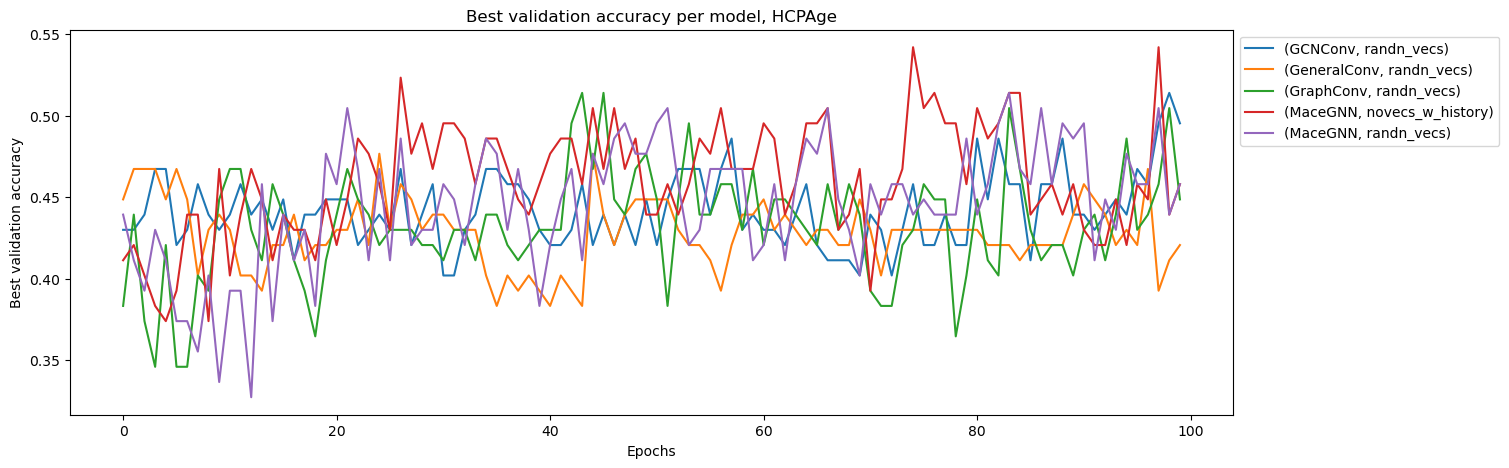

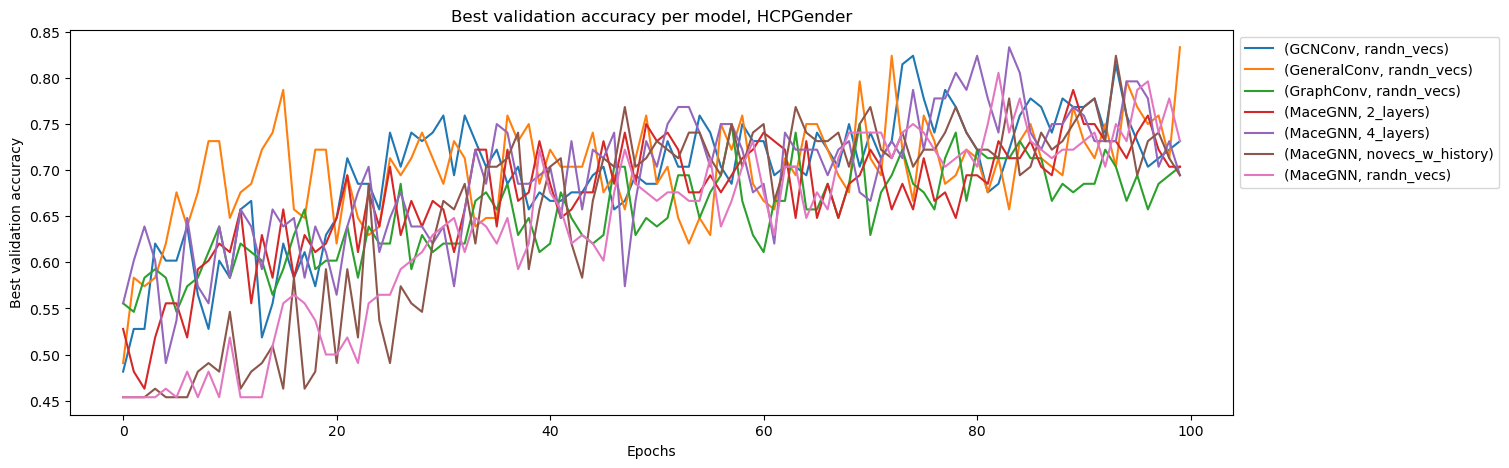

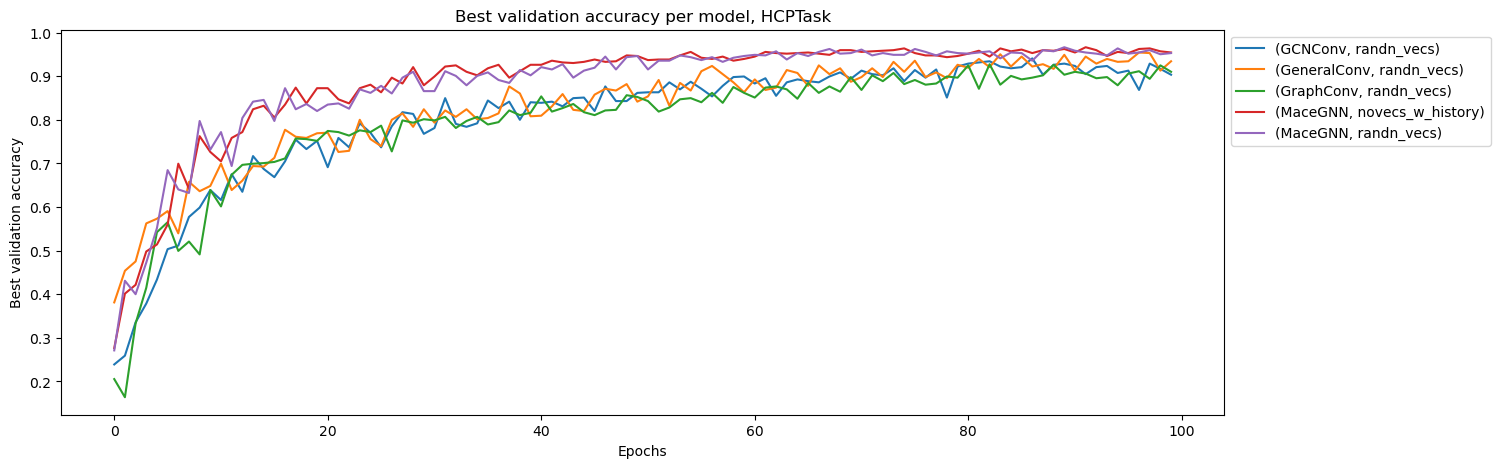

In [43]:
# Plot test_acc
for (dataset), g in his.groupby('dataset'):
    fig, ax = plt.subplots(figsize=(15, 5))
    for title, group in g[g.dataset == dataset].groupby(['model', 'label']):
        # group.plot('epoch', 'test_acc', label=title, ax=ax, style='--')
        # group.cummax().plot('epoch', 'val_acc', label=title, ax=ax)
        group.plot('epoch', 'val_acc', label=title, ax=ax)
    
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_title(f"Best validation accuracy per model, {dataset}")
    ax.set_ylabel("Best validation accuracy")
    ax.set_xlabel("Epochs")
    fig.show()

In [53]:
df[(df.model == "MaceGNN") & (df.dataset == "HCPGender") & ((df.label.str.contains('layers')) | (df.label == "novecs_w_history"))]

,label,dataset,model,epochs,best_val_acc,best_val_loss,test_acc,test_loss,valid_test_acc_diff
27,novecs_w_history,HCPGender,MaceGNN,100,82.407407,0.0,86.111111,15.632642,-3.703704
29,2_layers,HCPGender,MaceGNN,100,78.703704,0.0,80.555556,15.419774,-1.851852
30,4_layers,HCPGender,MaceGNN,100,83.333333,0.0,79.629630,15.833872,3.703704
